A temperature-forecasting example

In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-06 16:21:17--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.109.160, 52.217.232.16, 52.216.138.85, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.109.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  17.6MB/s    in 0.7s    

2024-04-06 16:21:18 (17.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features


In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Plotting the temperature timeseries



Text(0, 0.5, 'Temperature')

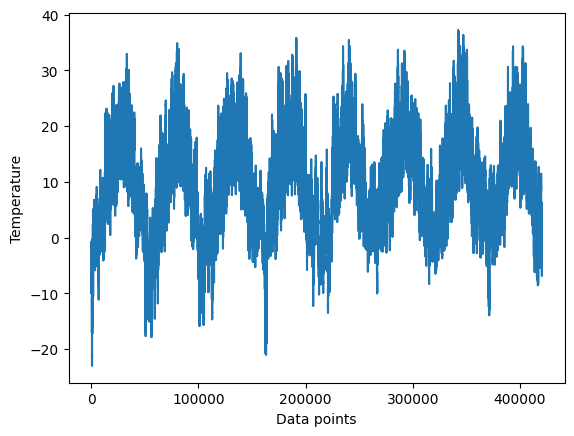

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points

Text(0, 0.5, 'Temperature')

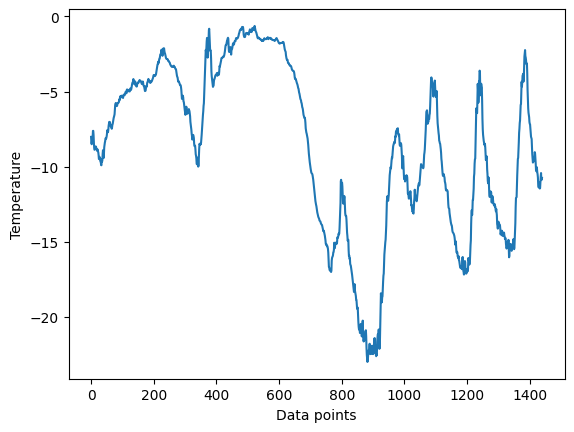

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**


In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Preparing the data

Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.



# Normalizing Data

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.



In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Inspecting the output of one of our datasets

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non-machine-learning baseline

Computing the common-sense baseline MAE

Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.




In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Assuming that the temperature in the next 24 hours will be the same as the current temperature is a sensible baseline strategy. The test MAE is 2.62 degrees Celsius, while the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius using this simple baseline. Put another way, an average divergence of roughly 2.5 degrees would arise from presuming that the future temperature stays constant with the current temperature.

Let's try a basic machine-learning model
Training and evaluating a densely connected model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 66s 79ms/step - loss: 14.6573 - mae: 2.9586 - val_loss: 11.2184 - val_mae: 2.6483
Epoch 2/10
819/819 [==============================] - 81s 99ms/step - loss: 10.0076 - mae: 2.4912 - val_loss: 10.6137 - val_mae: 2.5788
Epoch 3/10
819/819 [==============================] - 61s 74ms/step - loss: 9.2531 - mae: 2.3982 - val_loss: 10.5362 - val_mae: 2.5717
Epoch 4/10
819/819 [==============================] - 84s 102ms/step - loss: 8.6866 - mae: 2.3248 - val_loss: 12.6397 - val_mae: 2.8164
Epoch 5/10
819/819 [==============================] - 67s 81ms/step - loss: 8.3103 - mae: 2.2718 - val_loss: 9.9642 - val_mae: 2.4947
Epoch 6/10
819/819 [==============================] - 68s 83ms/step - loss: 7.9827 - mae: 2.2254 - val_loss: 10.2072 - val_mae: 2.5236
Epoch 7/10
819/819 [==============================] - 61s 74ms/step - loss: 7.7464 - mae: 2.1922 - val_loss: 10.1785 - val_mae: 2.5282
Epoch 8/10
819/819 [==============================] -

# Plotting results

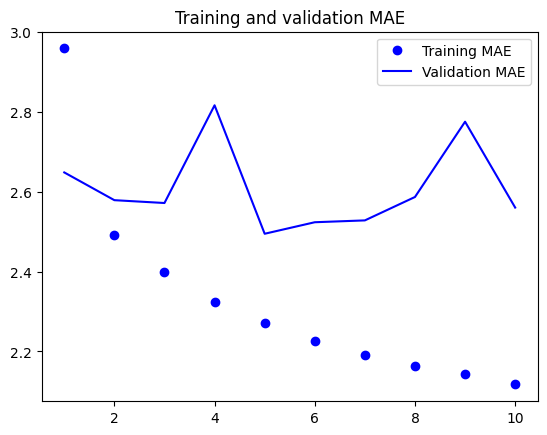

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Convolutional data appear to perform worse than dense models or common sense. It might be as a result of

For meteorological data, the translation invariance assumption is not very strong.


The data's order is very important. When it comes to forecasting the temperature for the next day, recent historical data is noticeably more useful than data collected several days prior. Sadly, this crucial temporal order is beyond the reach of a 1D convolutional neural network.


A Simple RNN

1.An RNN layer that can process sequences of any length

# Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 92s 111ms/step - loss: 144.3689 - mae: 9.8216 - val_loss: 146.9579 - val_mae: 9.9957
Epoch 2/10
819/819 [==============================] - 89s 108ms/step - loss: 129.0934 - mae: 9.1337 - val_loss: 133.2790 - val_mae: 9.4596
Epoch 3/10
819/819 [==============================] - 92s 112ms/step - loss: 115.6181 - mae: 8.5343 - val_loss: 118.8072 - val_mae: 8.8352
Epoch 4/10
819/819 [==============================] - 92s 112ms/step - loss: 103.3302 - mae: 7.9725 - val_loss: 106.4130 - val_mae: 8.2813
Epoch 5/10
819/819 [==============================] - 91s 111ms/step - loss: 92.0249 - mae: 7.4322 - val_loss: 95.7937 - val_mae: 7.8144
Epoch 6/10
819/819 [==============================] - 91s 110ms/step - loss: 81.7365 - mae: 6.9273 - val_loss: 85.4338 - val_mae: 7.3366
Epoch 7/10
819/819 [==============================] - 93s 113ms/step - loss: 72.3495 - mae: 6.4441 - val_loss: 76.3991 - val_mae: 6.9170
Epoch 8/10
819/819 [=============

A first recurrent baseline

A simple LSTM-based model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 137s 163ms/step - loss: 39.4042 - mae: 4.5690 - val_loss: 12.1552 - val_mae: 2.6505
Epoch 2/10
819/819 [==============================] - 117s 142ms/step - loss: 10.8303 - mae: 2.5563 - val_loss: 9.4756 - val_mae: 2.3982
Epoch 3/10
819/819 [==============================] - 119s 145ms/step - loss: 9.6212 - mae: 2.4175 - val_loss: 9.1814 - val_mae: 2.3586
Epoch 4/10
819/819 [==============================] - 132s 161ms/step - loss: 9.0793 - mae: 2.3456 - val_loss: 9.3274 - val_mae: 2.3680
Epoch 5/10
819/819 [==============================] - 120s 146ms/step - loss: 8.6840 - mae: 2.2965 - val_loss: 9.6812 - val_mae: 2.4151
Epoch 6/10
819/819 [==============================] - 117s 142ms/step - loss: 8.4041 - mae: 2.2601 - val_loss: 9.5877 - val_mae: 2.4078
Epoch 7/10
819/819 [==============================] - 117s 143ms/step - loss: 8.1957 - mae: 2.2309 - val_loss: 9.4457 - val_mae: 2.3883
Epoch 8/10
819/819 [=========================

# Understanding recurrent neural networks

NumPy implementation of a simple RNN

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stacEpoch 1/10
819/819 [==============================] - 137s 163ms/step - loss: 39.4042 - mae: 4.5690 - val_loss: 12.1552 - val_mae: 2.6505
Epoch 2/10
819/819 [==============================] - 117s 142ms/step - loss: 10.8303 - mae: 2.5563 - val_loss: 9.4756 - val_mae: 2.3982
Epoch 3/10
819/819 [==============================] - 119s 145ms/step - loss: 9.6212 - mae: 2.4175 - val_loss: 9.1814 - val_mae: 2.3586
Epoch 4/10
819/819 [==============================] - 132s 161ms/step - loss: 9.0793 - mae: 2.3456 - val_loss: 9.3274 - val_mae: 2.3680
Epoch 5/10
819/819 [==============================] - 120s 146ms/step - loss: 8.6840 - mae: 2.2965 - val_loss: 9.6812 - val_mae: 2.4151
Epoch 6/10
819/819 [==============================] - 117s 142ms/step - loss: 8.4041 - mae: 2.2601 - val_loss: 9.5877 - val_mae: 2.4078
Epoch 7/10
819/819 [==============================] - 117s 143ms/step - loss: 8.1957 - mae: 2.2309 - val_loss: 9.4457 - val_mae: 2.3883
Epoch 8/10
819/819 [==============================] - 117s 142ms/step - loss: 7.9938 - mae: 2.2050 - val_loss: 9.4777 - val_mae: 2.3918
Epoch 9/10
819/819 [==============================] - 116s 141ms/step - loss: 7.8228 - mae: 2.1821 - val_loss: 9.3846 - val_mae: 2.3842
Epoch 10/10
819/819 [==============================] - 131s 159ms/step - loss: 7.6911 - mae: 2.1637 - val_loss: 9.4141 - val_mae: 2.3921
405/405 [==============================] - 27s 65ms/step - loss: 10.4310 - mae: 2.5193
Test MAE: 2.52
Understanding recurrent neural networks
NumPy implementation of a simple RNN

[ ]
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []

A recurrent layer in Keras

An RNN layer that can process sequences of any length

k(successive_outputs, axis=0)

A recurrent layer in Keras

An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

An RNN layer that returns only its last output step

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


An RNN layer that returns its full output sequence

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


Stacking RNN layers

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

# Advanced use of recurrent neural networks

Using recurrent dropout to fight overfitting

Training and evaluating a dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 244s 294ms/step - loss: 29.0678 - mae: 3.9629 - val_loss: 9.9926 - val_mae: 2.4521
Epoch 2/10
819/819 [==============================] - 240s 292ms/step - loss: 14.9672 - mae: 2.9987 - val_loss: 9.2189 - val_mae: 2.3596
Epoch 3/10
819/819 [==============================] - 238s 290ms/step - loss: 13.9977 - mae: 2.9020 - val_loss: 8.9816 - val_mae: 2.3334
Epoch 4/10
819/819 [==============================] - 231s 282ms/step - loss: 13.3331 - mae: 2.8332 - val_loss: 9.0556 - val_mae: 2.3326
Epoch 5/10
819/819 [==============================] - 241s 294ms/step - loss: 12.9092 - mae: 2.7864 - val_loss: 8.7575 - val_mae: 2.2909
Epoch 6/10
819/819 [==============================] - 234s 284ms/step - loss: 12.4298 - mae: 2.7360 - val_loss: 9.0351 - val_mae: 2.3214
Epoch 7/10
819/819 [==============================] - 241s 294ms/step - loss: 12.1816 - mae: 2.7092 - val_loss: 8.8725 - val_mae: 2.3024
Epoch 8/10
819/819 [=====================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

# Stacking recurrent layers

Training and evaluating a dropout-regularized, stacked GRU model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 425s 510ms/step - loss: 25.1644 - mae: 3.7102 - val_loss: 9.9376 - val_mae: 2.4463
Epoch 2/10
819/819 [==============================] - 422s 515ms/step - loss: 14.0955 - mae: 2.9076 - val_loss: 9.0988 - val_mae: 2.3388
Epoch 3/10
819/819 [==============================] - 431s 526ms/step - loss: 13.3111 - mae: 2.8278 - val_loss: 8.8730 - val_mae: 2.3168
Epoch 4/10
819/819 [==============================] - 385s 469ms/step - loss: 12.8035 - mae: 2.7705 - val_loss: 9.1594 - val_mae: 2.3551
Epoch 5/10
819/819 [==============================] - 423s 516ms/step - loss: 12.4248 - mae: 2.7316 - val_loss: 8.7608 - val_mae: 2.3002
Epoch 6/10
819/819 [==============================] - 421s 514ms/step - loss: 12.0158 - mae: 2.6886 - val_loss: 8.8518 - val_mae: 2.3246
Epoch 7/10
819/819 [==============================] - 384s 469ms/step - loss: 11.5910 - mae: 2.6419 - val_loss: 8.5205 - val_mae: 2.2728
Epoch 8/10
819/819 [=====================

# Using bidirectional RNNs

Training and evaluating a bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 182s 217ms/step - loss: 25.7672 - mae: 3.6506 - val_loss: 10.4639 - val_mae: 2.5166
Epoch 2/10
819/819 [==============================] - 178s 217ms/step - loss: 9.5494 - mae: 2.4090 - val_loss: 9.5589 - val_mae: 2.3945
Epoch 3/10
819/819 [==============================] - 177s 216ms/step - loss: 8.5425 - mae: 2.2702 - val_loss: 10.0722 - val_mae: 2.4450
Epoch 4/10
819/819 [==============================] - 177s 216ms/step - loss: 7.8960 - mae: 2.1860 - val_loss: 10.2451 - val_mae: 2.4708
Epoch 5/10
819/819 [==============================] - 181s 220ms/step - loss: 7.4594 - mae: 2.1247 - val_loss: 10.7471 - val_mae: 2.5245
Epoch 6/10
819/819 [==============================] - 176s 215ms/step - loss: 7.2050 - mae: 2.0877 - val_loss: 10.7862 - val_mae: 2.5498
Epoch 7/10
819/819 [==============================] - 178s 217ms/step - loss: 6.8577 - mae: 2.0352 - val_loss: 11.5158 - val_mae: 2.6308
Epoch 8/10
819/819 [=====================

Going even further

# Summary

The above machine learning model is recurrent model with Long Short term memory. We have considered climate dataset. In this model we are assessing climate date by divinding into test and validation data with 10 epochs with batch size of 819, we are using Mean Absolute error function to see the loss in the performance

1) The training loss started with 25.76 which has decrease to 3.65 which tells that model has performed well in training data as the loss has reduced significantly

2) Based on the model performance the validation loss started from 10.46 which increased to 12.34 which shows that model performan is getting worse.

3) The validation MAE shows that MAE started at 2.56 and increased 2.7 which is degrading on the unseen data

Based on the above points we can assess that model ability to perform on training data increased model efficiency however when it comes to unseen data efficiency of the model has degraded which shows cleae sign of overfitting.

Based on the above overfitting issue, we can use dropout technique inorder to address overfitting issue.

We can tune hyperparameter like adjusting batch size, learning rate and LSTM parameter.

Based on the above recommendation the model to perform on training and unseen data accurately and can address overfitting issue.